# FedCAD: Federated vs Centralized Learning Analysis

This notebook provides comprehensive analysis and visualization of experiments comparing **Centralized** and **Federated Learning** approaches for breast cancer classification.

## 📋 Notebook Contents:

1. **Performance Metrics Comparison** - Side-by-side comparison of accuracy, precision, recall, F1, and AUC-ROC
2. **Training Efficiency** - Analysis of training time vs performance trade-offs
3. **Training Progress** - Evolution of metrics during training
4. **Federated Configuration Trade-offs** - Impact of local epochs vs server rounds on performance and efficiency
5. **Detailed Model Analysis** - ROC curves, confusion matrices, and classification reports
6. **Summary Statistics** - Key insights and best configurations
7. **Export Results** - Save results for reporting

## 🚀 Quick Start:

1. Run all cells in order
2. Results are fetched from W&B or loaded from CSV (fallback mode)
3. Visualizations and insights are generated automatically
4. Results are exported to `results/` directory

---

## Visualizations

### Importing Libraries

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
import os
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve
from torchvision.transforms import Compose, Normalize, ToTensor
from medmnist import BreastMNIST
from torch.utils.data import DataLoader

# Import your model and utility functions
import sys
sys.path.append('..')
from FedCAD.task import Net, load_data, test

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

In [3]:
# Optional: Install wandb if not already installed
# !pip install wandb -q

## 1. WandB Runs Comparison

**Note on Reproducibility**: This notebook can run in two modes:
- **WandB Mode**: Fetches live data from WandB (requires authentication and project access)
- **Offline Mode**: Uses exported CSV data (`wandb_runs_export.csv`) for reproducibility

The model evaluation section (Section 2) works independently and only requires the saved model file.

## Comparing Federated vs Centralized Training

This notebook compares two training approaches:
- **Centralized**: All data trained in one place (baseline)
- **Federated**: Data distributed across clients, trained collaboratively

### Key Metrics:
- **Performance**: accuracy, precision, recall, F1, AUC-ROC
- **Efficiency**: training time, convergence speed
- **Trade-offs**: communication rounds vs epochs

In [4]:
# Fetch runs from WandB API (if authenticated) or load from CSV
import wandb

try:
    api = wandb.Api()
    runs = api.runs("louisewiljander-ludwig-maximilianuniversity-of-munich/FedCAD", filters={"tags": {"$nin": ["random_search"]}})
    
    # Collect run data with all metrics
    run_data = []
    for run in runs:
        training_type = run.config.get('training_type', 'unknown')
        
        data = {
            'run_id': run.id,
            'name': run.name,
            'training_type': training_type,
            'state': run.state,
            'lr': run.config.get('lr', None),
            'final_test_acc': run.summary.get('final_test_acc', None),
            'final_test_loss': run.summary.get('final_test_loss', None),
            'final_precision': run.summary.get('final_precision', None),
            'final_recall': run.summary.get('final_recall', None),
            'final_f1': run.summary.get('final_f1', None),
            'final_auc_roc': run.summary.get('final_auc_roc', None),
            'total_training_time_min': run.summary.get('total_training_time_min', None),
            'tags': ','.join(run.tags) if hasattr(run, 'tags') and run.tags else None,
        }
        
        # Add type-specific metrics
        if training_type == 'centralized':
            data['epochs'] = run.config.get('epochs', None)
            data['total_steps'] = run.config.get('epochs', 0)
        elif training_type == 'federated':
            data['num_rounds'] = run.config.get('num_rounds', None)
            data['local_epochs'] = run.config.get('local_epochs', None)
            data['total_local_epochs'] = run.config.get('total_local_epochs', None)
            data['total_steps'] = run.config.get('total_local_epochs', 0)
        
        run_data.append(data)
    
    df_comparison = pd.DataFrame(run_data)
    df_comparison.to_csv('results.csv', index=False)
    print(f"✅ Fetched {len(df_comparison)} runs from WandB (group='comparison')")
    
except Exception as e:
    print(f"⚠️ Could not fetch from WandB: {e}")
    print("Trying to load from CSV...")
    try:
        df_comparison = pd.read_csv('wandb_comparison_export.csv')
        print(f"✅ Loaded {len(df_comparison)} runs from CSV")
    except:
        print("❌ No data available")
        df_comparison = pd.DataFrame()

if not df_comparison.empty:
    print(f"\nData Summary:")
    print(f"  Centralized runs: {len(df_comparison[df_comparison['training_type']=='centralized'])}")
    print(f"  Federated runs: {len(df_comparison[df_comparison['training_type']=='federated'])}")
    display(df_comparison[['name', 'training_type', 'final_test_acc', 'final_f1', 'total_training_time_min']].head(10))

✅ Fetched 120 runs from WandB (group='comparison')

Data Summary:
  Centralized runs: 60
  Federated runs: 60


,name,training_type,final_test_acc,final_f1,total_training_time_min
0,federated_lr0.001_r3_le10,federated,0.754545,0.740364,0.333043
1,federated_lr0.001_r3_le10,federated,0.772727,0.774191,0.217928
2,federated_lr0.001_r3_le10,federated,0.754545,0.735099,0.213160
3,federated_lr0.001_r3_le10,federated,0.745455,0.733242,0.209461
4,federated_lr0.001_r3_le10,federated,0.709091,0.723345,0.239761
5,federated_lr0.001_r3_le10,federated,0.763636,0.661293,0.211067
6,federated_lr0.001_r1_le30,federated,0.790909,0.731704,0.257559
7,federated_lr0.001_r1_le30,federated,0.790909,0.720583,0.201505
8,federated_lr0.001_r1_le30,federated,0.763636,0.661293,0.225055
9,federated_lr0.001_r1_le30,federated,0.772727,0.682228,0.210095


### 1. Performance Metrics Comparison

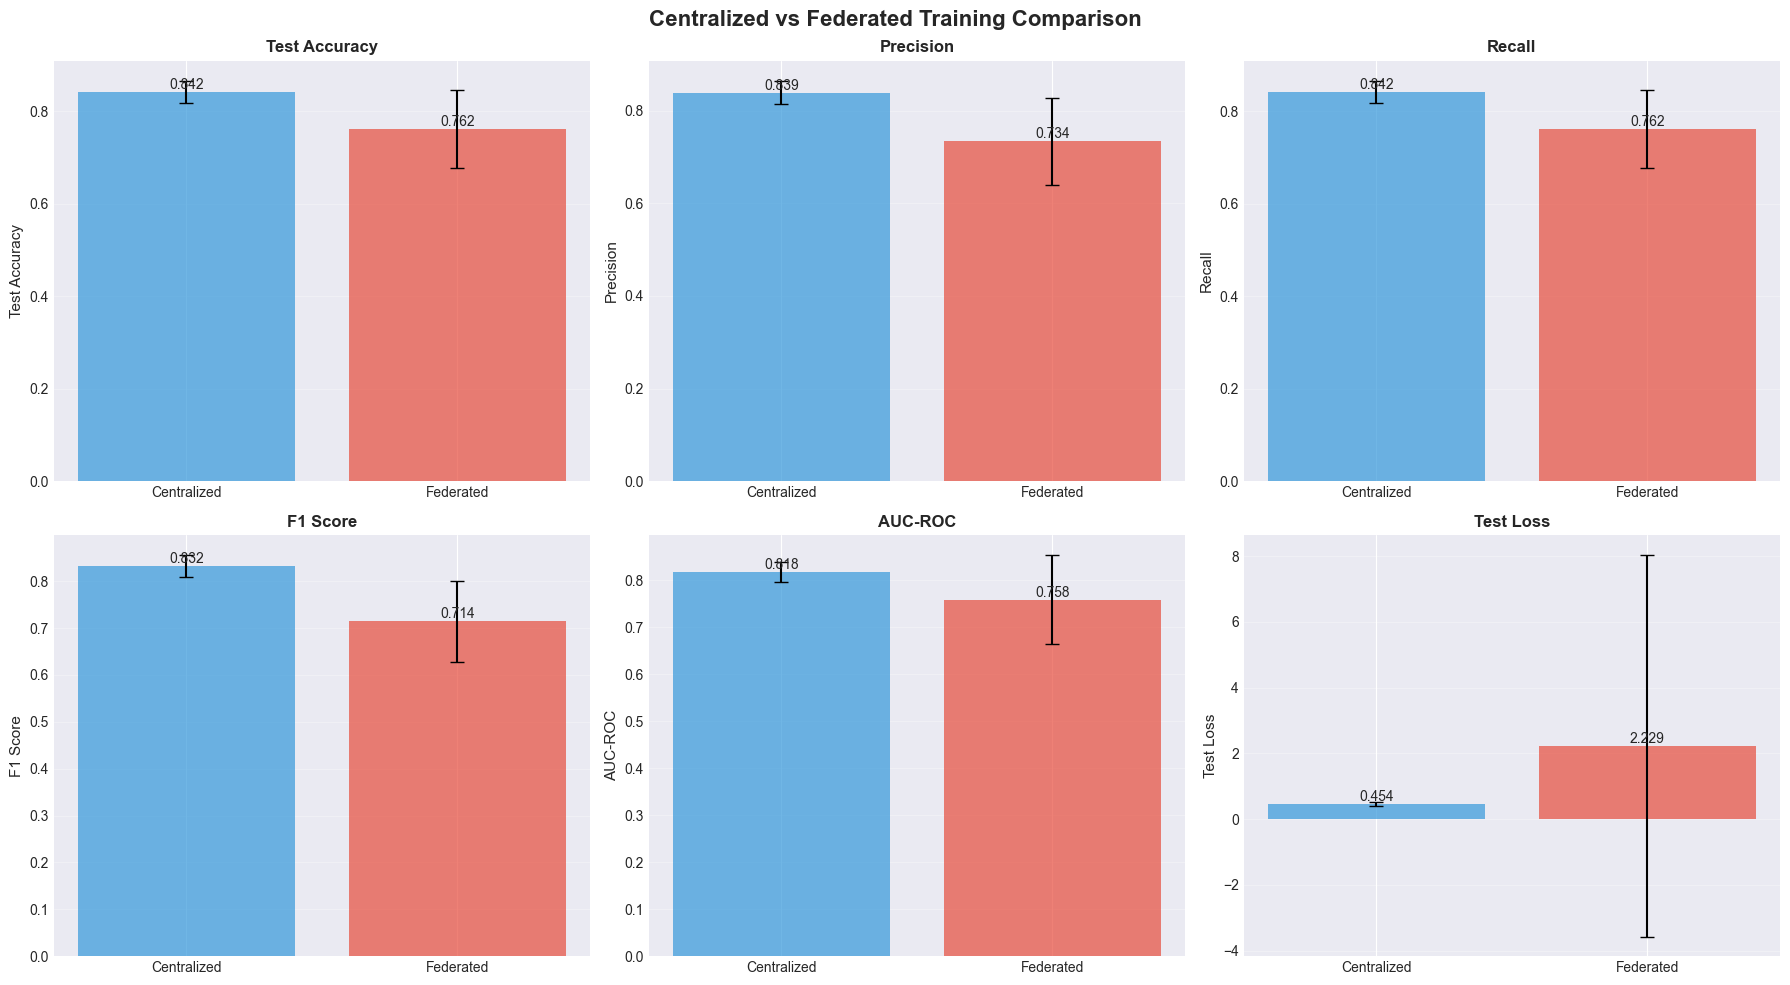


📊 Numerical Comparison (Mean ± Std):
Test Accuracy        | Central: 0.842±0.024 | Federated: 0.762±0.084
Precision            | Central: 0.839±0.026 | Federated: 0.734±0.095
Recall               | Central: 0.842±0.024 | Federated: 0.762±0.084
F1 Score             | Central: 0.832±0.023 | Federated: 0.714±0.087
AUC-ROC              | Central: 0.818±0.021 | Federated: 0.758±0.094
Test Loss            | Central: 0.454±0.051 | Federated: 2.229±5.817
⚠️ Unrecognized tags for run 7cowldos: centralized
⚠️ Unrecognized tags for run 269ei386: centralized
⚠️ Unrecognized tags for run iy7k1oan: centralized
⚠️ Unrecognized tags for run 60rjejym: centralized
⚠️ Unrecognized tags for run ksizaacs: centralized
⚠️ Unrecognized tags for run hlwpvm4f: centralized
⚠️ Unrecognized tags for run hb59jqak: centralized
⚠️ Unrecognized tags for run 6559xtrt: centralized
⚠️ Unrecognized tags for run 7m3uouxj: centralized
⚠️ Unrecognized tags for run rfgx5x8s: centralized
⚠️ Unrecognized tags for run qvovn4zw:

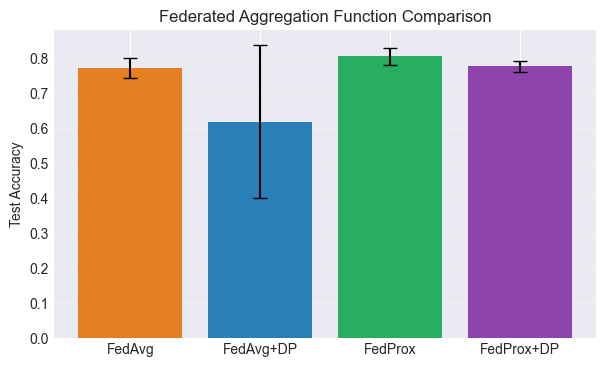

In [14]:
if not df_comparison.empty:
    # Filter to get the best run of each type
    centralized_runs = df_comparison[df_comparison['training_type'] == 'centralized']
    federated_runs = df_comparison[df_comparison['training_type'] == 'federated']
    
    # Create comparison bar chart
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle('Centralized vs Federated Training Comparison', fontsize=16, fontweight='bold')
    
    metrics = [
        ('final_test_acc', 'Test Accuracy', axes[0, 0]),
        ('final_precision', 'Precision', axes[0, 1]),
        ('final_recall', 'Recall', axes[0, 2]),
        ('final_f1', 'F1 Score', axes[1, 0]),
        ('final_auc_roc', 'AUC-ROC', axes[1, 1]),
        ('final_test_loss', 'Test Loss', axes[1, 2])
    ]
    
    for metric, label, ax in metrics:
        if centralized_runs[metric].notna().any() and federated_runs[metric].notna().any():
            central_mean = centralized_runs[metric].mean()
            fed_mean = federated_runs[metric].mean()
            central_std = centralized_runs[metric].std()
            fed_std = federated_runs[metric].std()
            
            x = ['Centralized', 'Federated']
            y = [central_mean, fed_mean]
            err = [central_std, fed_std]
            
            bars = ax.bar(x, y, yerr=err, capsize=5, alpha=0.7, 
                         color=['#3498db', '#e74c3c'])
            ax.set_ylabel(label, fontsize=11)
            ax.set_title(label, fontsize=12, fontweight='bold')
            ax.grid(axis='y', alpha=0.3)
            
            # Add value labels on bars
            for bar, val in zip(bars, y):
                height = bar.get_height()
                ax.text(bar.get_x() + bar.get_width()/2., height,
                       f'{val:.3f}', ha='center', va='bottom', fontsize=10)
    
    plt.tight_layout()
    plt.show()
    
    # Print numerical comparison
    print("\n📊 Numerical Comparison (Mean ± Std):")
    print("="*70)
    for metric, label, _ in metrics:
        if centralized_runs[metric].notna().any() and federated_runs[metric].notna().any():
            c_mean, c_std = centralized_runs[metric].mean(), centralized_runs[metric].std()
            f_mean, f_std = federated_runs[metric].mean(), federated_runs[metric].std()
            print(f"{label:20s} | Central: {c_mean:.3f}±{c_std:.3f} | Federated: {f_mean:.3f}±{f_std:.3f}")
    centralized_runs = df_comparison[df_comparison['training_type'] == 'centralized']
    federated_runs = df_comparison[df_comparison['training_type'] == 'federated']
    if 'tags' in df_comparison.columns:
        def get_agg(row):
            tags = row['tags']
            if isinstance(tags, str):
                tags_lower = tags.lower()
                if 'optimal-fedprox-dp' in tags_lower:
                    return 'FedProx+DP'
                elif 'fedprox' in tags_lower:
                    return 'FedProx'
                elif 'dp-fedavg' in tags_lower:
                    return 'FedAvg+DP'
                elif 'fedavg' in tags_lower:
                    return 'FedAvg'
            print(f"⚠️ Unrecognized tags for run {row['run_id']}: {tags}")
            return 'Unknown'
        df_comparison['aggregation'] = df_comparison.apply(get_agg, axis=1)
        agg_groups = df_comparison[df_comparison['training_type'] == 'federated'].groupby('aggregation')

        print("\n🔄 Federated Aggregation Function Comparison")
        print("="*60)
        for agg, group in agg_groups:
            if not group.empty:
                mean_acc = group['final_test_acc'].mean()
                std_acc = group['final_test_acc'].std()
                mean_f1 = group['final_f1'].mean()
                mean_time = group['total_training_time_min'].mean()
                print(f"{agg:12s} | Accuracy: {mean_acc:.4f} ± {std_acc:.4f} | F1: {mean_f1:.4f} | Time: {mean_time:.2f} min | n={len(group)}")
        # Optional: Bar plot for visual comparison
        import matplotlib.pyplot as plt
        agg_perf = agg_groups['final_test_acc'].agg(['mean', 'std', 'count']).reset_index()
        plt.figure(figsize=(7,4))
        plt.bar(agg_perf['aggregation'], agg_perf['mean'], yerr=agg_perf['std'], capsize=5, color=['#e67e22','#2980b9','#27ae60','#8e44ad'])
        plt.ylabel('Test Accuracy')
        plt.title('Federated Aggregation Function Comparison')
        plt.grid(axis='y', alpha=0.3)
        plt.show()
else:
    print("No comparison data available")

### COMPARE AGGREGATION FUNCTIONS IN FEDERATED LEARNING

    



### 2. Training Efficiency: Accuracy vs Time

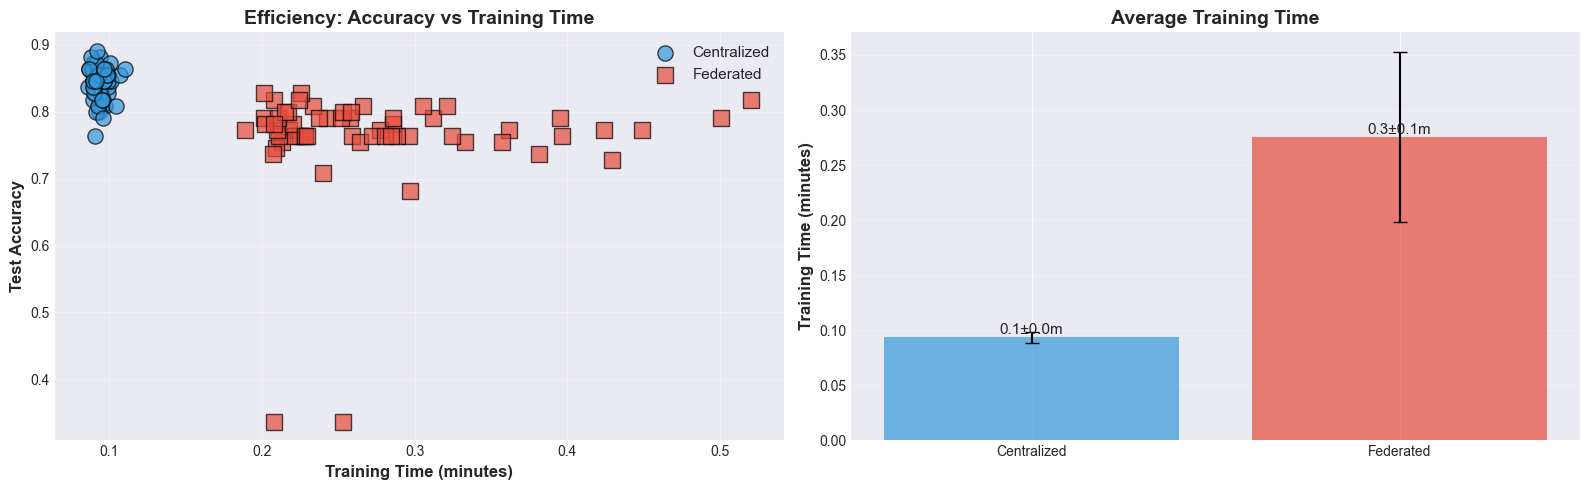


⏱️ Training Efficiency:
Centralized: 0.09 ± 0.00 minutes
Federated: 0.28 ± 0.08 minutes


In [6]:
if not df_comparison.empty:
    fig, axes = plt.subplots(1, 2, figsize=(16, 5))
    
    # Plot 1: Accuracy vs Training Time
    ax = axes[0]
    for training_type, color, marker in [('centralized', '#3498db', 'o'), 
                                          ('federated', '#e74c3c', 's')]:
        data = df_comparison[df_comparison['training_type'] == training_type]
        if not data.empty:
            ax.scatter(data['total_training_time_min'], data['final_test_acc'],
                      s=120, alpha=0.7, color=color, marker=marker, 
                      label=training_type.capitalize(), edgecolors='black', linewidth=1)
    
    ax.set_xlabel('Training Time (minutes)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Test Accuracy', fontsize=12, fontweight='bold')
    ax.set_title('Efficiency: Accuracy vs Training Time', fontsize=14, fontweight='bold')
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)
    
    # Plot 2: Training time comparison
    ax = axes[1]
    if centralized_runs['total_training_time_min'].notna().any() and \
       federated_runs['total_training_time_min'].notna().any():
        
        c_time = centralized_runs['total_training_time_min'].mean()
        f_time = federated_runs['total_training_time_min'].mean()
        c_std = centralized_runs['total_training_time_min'].std()
        f_std = federated_runs['total_training_time_min'].std()
        
        bars = ax.bar(['Centralized', 'Federated'], [c_time, f_time],
                     yerr=[c_std, f_std], capsize=5, alpha=0.7,
                     color=['#3498db', '#e74c3c'])
        
        ax.set_ylabel('Training Time (minutes)', fontsize=12, fontweight='bold')
        ax.set_title('Average Training Time', fontsize=14, fontweight='bold')
        ax.grid(axis='y', alpha=0.3)
        
        # Add value labels
        for bar, val, std in zip(bars, [c_time, f_time], [c_std, f_std]):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{val:.1f}±{std:.1f}m', ha='center', va='bottom', fontsize=11)
    
    plt.tight_layout()
    plt.show()
    
    print("\n⏱️ Training Efficiency:")
    print(f"Centralized: {centralized_runs['total_training_time_min'].mean():.2f} ± {centralized_runs['total_training_time_min'].std():.2f} minutes")
    print(f"Federated: {federated_runs['total_training_time_min'].mean():.2f} ± {federated_runs['total_training_time_min'].std():.2f} minutes")
else:
    print("No timing data available")

### 3. Training Progress Over Time

Visualize how test accuracy and loss evolve during training for both approaches.

Could not fetch training history: Could not find run <Run vae-seminar/FedCAD/sxi2mxga (not found)>
Skipping training progress plots


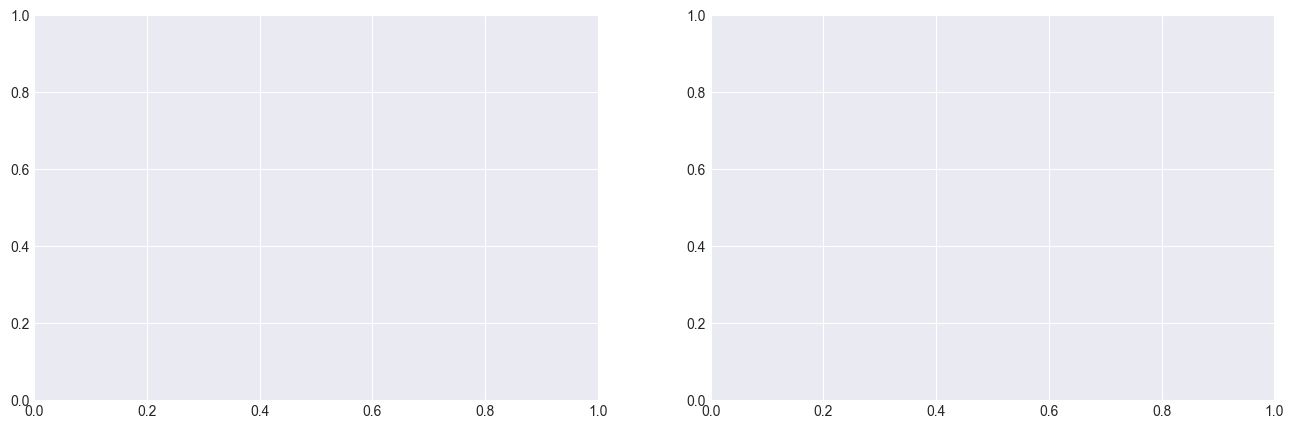

In [7]:
if not df_comparison.empty and len(df_comparison) > 0:
    try:
        # Fetch training history for best run of each type
        api = wandb.Api()
        
        fig, axes = plt.subplots(1, 2, figsize=(16, 5))
        
        for training_type, color, ax_idx in [('centralized', '#3498db', 0), 
                                              ('federated', '#e74c3c', 1)]:
            runs_of_type = df_comparison[df_comparison['training_type'] == training_type]
            if not runs_of_type.empty:
                # Get best run
                best_run_id = runs_of_type.nlargest(1, 'final_test_acc').iloc[0]['run_id']
                run = api.run(f"FedCAD/{best_run_id}")
                history = run.history()
                
                # Plot test accuracy over time
                if training_type == 'centralized' and 'test_acc' in history.columns:
                    history_clean = history[history['test_acc'].notna()]
                    axes[0].plot(history_clean['epoch'], history_clean['test_acc'],
                               marker='o', linewidth=2, color=color, 
                               label=f'{training_type.capitalize()}', markersize=6)
                    axes[1].plot(history_clean['epoch'], history_clean['test_loss'],
                               marker='o', linewidth=2, color=color,
                               label=f'{training_type.capitalize()}', markersize=6)
                    
                elif training_type == 'federated' and 'test_acc' in history.columns:
                    history_clean = history[history['test_acc'].notna()]
                    axes[0].plot(history_clean['round'], history_clean['test_acc'],
                               marker='s', linewidth=2, color=color,
                               label=f'{training_type.capitalize()}', markersize=6)
                    axes[1].plot(history_clean['round'], history_clean['test_loss'],
                               marker='s', linewidth=2, color=color,
                               label=f'{training_type.capitalize()}', markersize=6)
        
        # Format accuracy plot
        axes[0].set_xlabel('Epoch / Round', fontsize=12, fontweight='bold')
        axes[0].set_ylabel('Test Accuracy', fontsize=12, fontweight='bold')
        axes[0].set_title('Test Accuracy Over Training', fontsize=14, fontweight='bold')
        axes[0].legend(fontsize=11)
        axes[0].grid(True, alpha=0.3)
        
        # Format loss plot
        axes[1].set_xlabel('Epoch / Round', fontsize=12, fontweight='bold')
        axes[1].set_ylabel('Test Loss', fontsize=12, fontweight='bold')
        axes[1].set_title('Test Loss Over Training', fontsize=14, fontweight='bold')
        axes[1].legend(fontsize=11)
        axes[1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"Could not fetch training history: {e}")
        print("Skipping training progress plots")
else:
    print("No data available for training progress plots")

### 4. Federated Learning Configuration Trade-offs

Compare different federated learning setups: local epochs vs server rounds, and their impact on performance and efficiency.

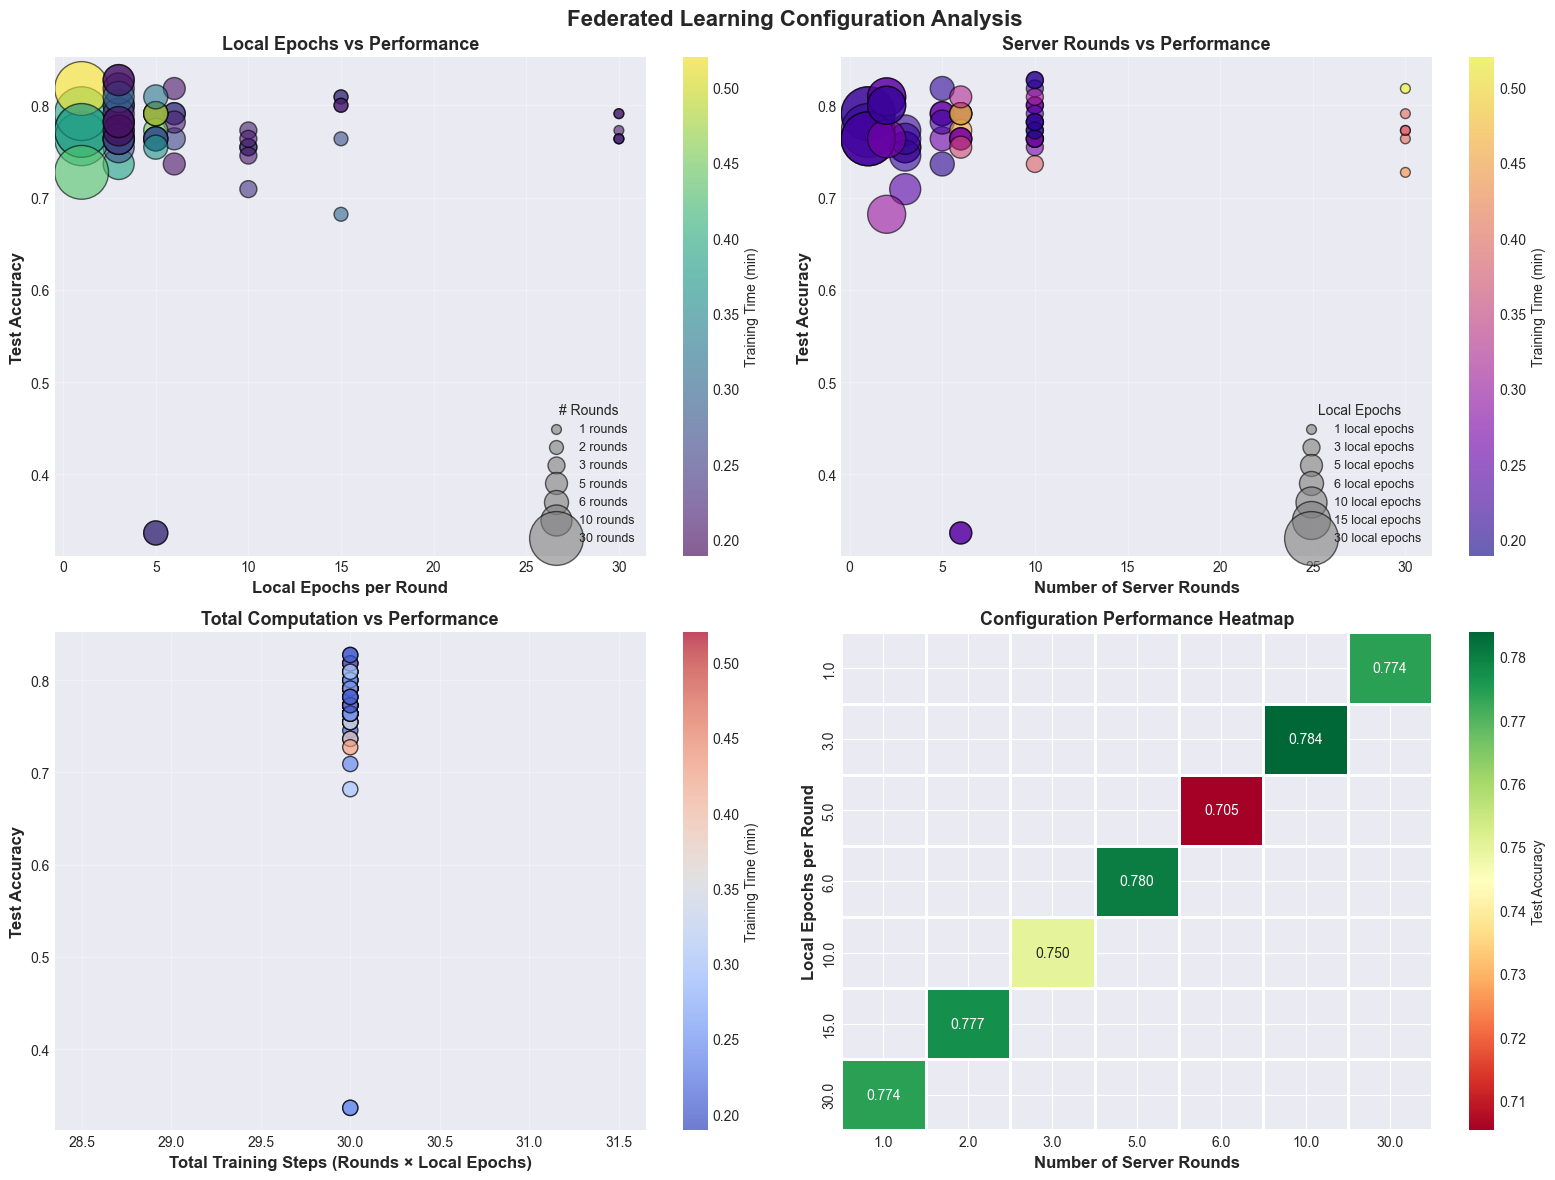


🔍 Federated Configuration Analysis:
Rounds: 3 | Local Epochs: 10 | Total Steps: 30 | Accuracy: 0.755 | Time: 0.33min
Rounds: 3 | Local Epochs: 10 | Total Steps: 30 | Accuracy: 0.773 | Time: 0.22min
Rounds: 3 | Local Epochs: 10 | Total Steps: 30 | Accuracy: 0.755 | Time: 0.21min
Rounds: 3 | Local Epochs: 10 | Total Steps: 30 | Accuracy: 0.745 | Time: 0.21min
Rounds: 3 | Local Epochs: 10 | Total Steps: 30 | Accuracy: 0.709 | Time: 0.24min
Rounds: 3 | Local Epochs: 10 | Total Steps: 30 | Accuracy: 0.764 | Time: 0.21min
Rounds: 1 | Local Epochs: 30 | Total Steps: 30 | Accuracy: 0.791 | Time: 0.26min
Rounds: 1 | Local Epochs: 30 | Total Steps: 30 | Accuracy: 0.791 | Time: 0.20min
Rounds: 1 | Local Epochs: 30 | Total Steps: 30 | Accuracy: 0.764 | Time: 0.23min
Rounds: 1 | Local Epochs: 30 | Total Steps: 30 | Accuracy: 0.773 | Time: 0.21min
Rounds: 1 | Local Epochs: 30 | Total Steps: 30 | Accuracy: 0.764 | Time: 0.23min
Rounds: 1 | Local Epochs: 30 | Total Steps: 30 | Accuracy: 0.764 | Time:

In [8]:
if not df_comparison.empty:
    federated_only = df_comparison[df_comparison['training_type'] == 'federated'].copy()
    
    if not federated_only.empty and len(federated_only) > 1:
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        fig.suptitle('Federated Learning Configuration Analysis', fontsize=16, fontweight='bold')
        
        # Plot 1: Local Epochs vs Accuracy
        ax = axes[0, 0]
        scatter = ax.scatter(federated_only['local_epochs'], federated_only['final_test_acc'],
                           s=federated_only['num_rounds']*50, alpha=0.6, 
                           c=federated_only['total_training_time_min'], cmap='viridis',
                           edgecolors='black', linewidth=1)
        ax.set_xlabel('Local Epochs per Round', fontsize=12, fontweight='bold')
        ax.set_ylabel('Test Accuracy', fontsize=12, fontweight='bold')
        ax.set_title('Local Epochs vs Performance', fontsize=13, fontweight='bold')
        ax.grid(True, alpha=0.3)
        cbar = plt.colorbar(scatter, ax=ax)
        cbar.set_label('Training Time (min)', fontsize=10)
        
        # Add legend for bubble size
        for rounds in sorted(federated_only['num_rounds'].dropna().unique()):
            ax.scatter([], [], s=rounds*50, c='gray', alpha=0.6, 
                      edgecolors='black', linewidth=1,
                      label=f'{int(rounds)} rounds')
        ax.legend(title='# Rounds', loc='lower right', fontsize=9)
        
        # Plot 2: Server Rounds vs Accuracy
        ax = axes[0, 1]
        scatter = ax.scatter(federated_only['num_rounds'], federated_only['final_test_acc'],
                           s=federated_only['local_epochs']*50, alpha=0.6,
                           c=federated_only['total_training_time_min'], cmap='plasma',
                           edgecolors='black', linewidth=1)
        ax.set_xlabel('Number of Server Rounds', fontsize=12, fontweight='bold')
        ax.set_ylabel('Test Accuracy', fontsize=12, fontweight='bold')
        ax.set_title('Server Rounds vs Performance', fontsize=13, fontweight='bold')
        ax.grid(True, alpha=0.3)
        cbar = plt.colorbar(scatter, ax=ax)
        cbar.set_label('Training Time (min)', fontsize=10)
        
        # Add legend for bubble size
        for epochs in sorted(federated_only['local_epochs'].dropna().unique()):
            ax.scatter([], [], s=epochs*50, c='gray', alpha=0.6,
                      edgecolors='black', linewidth=1,
                      label=f'{int(epochs)} local epochs')
        ax.legend(title='Local Epochs', loc='lower right', fontsize=9)
        
        # Plot 3: Total Training Steps (rounds × local_epochs) vs Efficiency
        ax = axes[1, 0]
        federated_only['total_steps'] = federated_only['num_rounds'] * federated_only['local_epochs']
        scatter = ax.scatter(federated_only['total_steps'], federated_only['final_test_acc'],
                           s=120, alpha=0.7, c=federated_only['total_training_time_min'],
                           cmap='coolwarm', edgecolors='black', linewidth=1)
        ax.set_xlabel('Total Training Steps (Rounds × Local Epochs)', fontsize=12, fontweight='bold')
        ax.set_ylabel('Test Accuracy', fontsize=12, fontweight='bold')
        ax.set_title('Total Computation vs Performance', fontsize=13, fontweight='bold')
        ax.grid(True, alpha=0.3)
        cbar = plt.colorbar(scatter, ax=ax)
        cbar.set_label('Training Time (min)', fontsize=10)
        
        # Plot 4: Configuration Efficiency Heatmap
        ax = axes[1, 1]
        if federated_only['num_rounds'].notna().any() and federated_only['local_epochs'].notna().any():
            # Create pivot table for heatmap
            pivot_data = federated_only.pivot_table(
                values='final_test_acc',
                index='local_epochs',
                columns='num_rounds',
                aggfunc='mean'
            )
            
            if not pivot_data.empty:
                sns.heatmap(pivot_data, annot=True, fmt='.3f', cmap='RdYlGn',
                           ax=ax, cbar_kws={'label': 'Test Accuracy'},
                           linewidths=1, linecolor='white')
                ax.set_xlabel('Number of Server Rounds', fontsize=12, fontweight='bold')
                ax.set_ylabel('Local Epochs per Round', fontsize=12, fontweight='bold')
                ax.set_title('Configuration Performance Heatmap', fontsize=13, fontweight='bold')
            else:
                ax.text(0.5, 0.5, 'Insufficient data for heatmap', 
                       ha='center', va='center', transform=ax.transAxes)
                ax.set_title('Configuration Performance Heatmap', fontsize=13, fontweight='bold')
        
        plt.tight_layout()
        plt.show()
        
        # Print configuration analysis
        print("\n🔍 Federated Configuration Analysis:")
        print("="*70)
        if 'total_steps' in federated_only.columns:
            for _, row in federated_only.iterrows():
                print(f"Rounds: {row['num_rounds']:.0f} | Local Epochs: {row['local_epochs']:.0f} | "
                      f"Total Steps: {row['total_steps']:.0f} | "
                      f"Accuracy: {row['final_test_acc']:.3f} | "
                      f"Time: {row['total_training_time_min']:.2f}min")
    else:
        print("Need at least 2 federated runs with different configurations for comparison")
else:
    print("No federated data available")

### 5. Model Performance Detailed Analysis

ROC curves, confusion matrices, and per-class metrics for the best models.

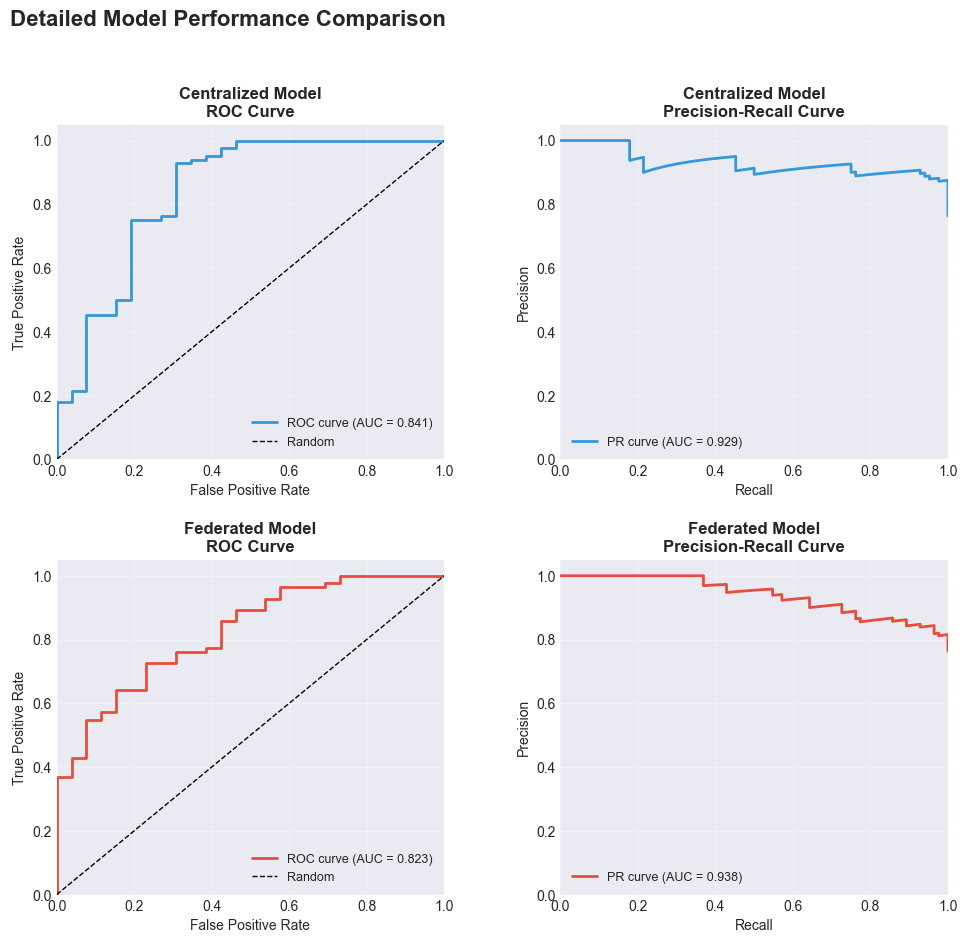


📈 Detailed Classification Metrics:


Centralized Model
              precision    recall  f1-score   support

     Class 0       1.00      0.54      0.70        26
     Class 1       0.88      1.00      0.93        84

    accuracy                           0.89       110
   macro avg       0.94      0.77      0.82       110
weighted avg       0.90      0.89      0.88       110


Federated Model
              precision    recall  f1-score   support

     Class 0       0.56      0.58      0.57        26
     Class 1       0.87      0.86      0.86        84

    accuracy                           0.79       110
   macro avg       0.71      0.72      0.71       110
weighted avg       0.79      0.79      0.79       110



In [9]:
# Load and evaluate the best models from each approach
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
_, testloader = load_data(0, 1)

def evaluate_model_detailed(model_path, model_name):
    """Evaluate model and return predictions, probabilities, and labels"""
    try:
        model = Net()
        model.load_state_dict(torch.load(model_path, map_location=device))
        model.to(device)
        model.eval()
        
        all_preds, all_probs, all_labels = [], [], []
        
        with torch.no_grad():
            for images, labels in testloader:
                images = images.to(device)
                labels = labels.squeeze().long()
                outputs = model(images)
                probs = torch.softmax(outputs, dim=1)
                preds = torch.argmax(outputs, dim=1)
                
                all_preds.extend(preds.cpu().numpy())
                all_probs.extend(probs.cpu().numpy())
                all_labels.extend(labels.numpy())
        
        return (np.array(all_preds), np.array(all_probs), np.array(all_labels))
    except Exception as e:
        print(f"Could not load {model_name}: {e}")
        return None, None, None

# Evaluate both models
centralized_results = evaluate_model_detailed('models/final_model_centralized.pt', 'Centralized')
federated_results = evaluate_model_detailed('final_model.pt', 'Federated')

# Create comprehensive visualization
fig = plt.figure(figsize=(18, 10))
gs = fig.add_gridspec(2, 3, hspace=0.3, wspace=0.3)

model_results = [
    ('Centralized', centralized_results, '#3498db'),
    ('Federated', federated_results, '#e74c3c')
]

for idx, (name, results, color) in enumerate(model_results):
    if results[0] is not None:
        preds, probs, labels = results
    
        
        # ROC Curve
        ax_roc = fig.add_subplot(gs[idx, 1])
        fpr, tpr, _ = roc_curve(labels, probs[:, 1])
        roc_auc = auc(fpr, tpr)
        ax_roc.plot(fpr, tpr, color=color, lw=2, 
                   label=f'ROC curve (AUC = {roc_auc:.3f})')
        ax_roc.plot([0, 1], [0, 1], 'k--', lw=1, label='Random')
        ax_roc.set_xlim([0.0, 1.0])
        ax_roc.set_ylim([0.0, 1.05])
        ax_roc.set_xlabel('False Positive Rate', fontsize=10)
        ax_roc.set_ylabel('True Positive Rate', fontsize=10)
        ax_roc.set_title(f'{name} Model\nROC Curve', fontsize=12, fontweight='bold')
        ax_roc.legend(loc="lower right", fontsize=9)
        ax_roc.grid(True, alpha=0.3)
        
        # Precision-Recall Curve
        ax_pr = fig.add_subplot(gs[idx, 2])
        precision, recall, _ = precision_recall_curve(labels, probs[:, 1])
        pr_auc = auc(recall, precision)
        ax_pr.plot(recall, precision, color=color, lw=2,
                  label=f'PR curve (AUC = {pr_auc:.3f})')
        ax_pr.set_xlim([0.0, 1.0])
        ax_pr.set_ylim([0.0, 1.05])
        ax_pr.set_xlabel('Recall', fontsize=10)
        ax_pr.set_ylabel('Precision', fontsize=10)
        ax_pr.set_title(f'{name} Model\nPrecision-Recall Curve', fontsize=12, fontweight='bold')
        ax_pr.legend(loc="lower left", fontsize=9)
        ax_pr.grid(True, alpha=0.3)

fig.suptitle('Detailed Model Performance Comparison', fontsize=16, fontweight='bold', y=0.995)
plt.show()

# Print classification reports
print("\n📈 Detailed Classification Metrics:\n")
for name, results, _ in model_results:
    if results[0] is not None:
        preds, _, labels = results
        print(f"\n{'='*50}")
        print(f"{name} Model")
        print(f"{'='*50}")
        print(classification_report(labels, preds, target_names=['Class 0', 'Class 1']))

### 6. Summary Statistics & Key Insights

In [10]:
if not df_comparison.empty:
    print("="*80)
    print(" "*25 + "EXPERIMENT SUMMARY")
    print("="*80)
    
    # Overall statistics
    centralized = df_comparison[df_comparison['training_type'] == 'centralized']
    federated = df_comparison[df_comparison['training_type'] == 'federated']
    for training_type in ['centralized', 'federated']:
        subset = df_comparison[df_comparison['training_type'] == training_type]
        if not subset.empty:
            stats = {
                'training_type': training_type,
                'count': len(subset),
                'mean_test_acc': subset['final_test_acc'].mean(),
                'std_test_acc': subset['final_test_acc'].std(),
                'mean_precision': subset['final_precision'].mean(),
                'mean_recall': subset['final_recall'].mean(),
                'mean_f1': subset['final_f1'].mean(),
                'mean_auc_roc': subset['final_auc_roc'].mean(),
                'mean_training_time_min': subset['total_training_time_min'].mean(),
                'std_training_time_min': subset['total_training_time_min'].std(),
            }
    
    print(f"\n📊 Dataset & Training Overview:")
    print(f"   Total Experiments: {len(df_comparison)}")
    print(f"   Centralized Runs: {len(centralized)}")
    print(f"   Federated Runs: {len(federated)}")
    
    # Performance comparison
    print(f"\n🎯 Performance Comparison:")
    print(f"   {'Metric':<20} {'Centralized':<20} {'Federated':<20} {'Difference'}")
    print(f"   {'-'*75}")
    
    metrics_to_compare = [
        ('final_test_acc', 'Test Accuracy'),
        ('final_precision', 'Precision'),
        ('final_recall', 'Recall'),
        ('final_f1', 'F1 Score'),
        ('final_auc_roc', 'AUC-ROC'),
    ]
    
    for metric, label in metrics_to_compare:
        if metric in centralized.columns and metric in federated.columns:
            c_val = centralized[metric].mean()
            f_val = federated[metric].mean()
            diff = f_val - c_val
            diff_pct = (diff / c_val * 100) if c_val != 0 else 0
            
            print(f"   {label:<20} {c_val:.4f} ± {centralized[metric].std():.4f}   "
                  f"{f_val:.4f} ± {federated[metric].std():.4f}   "
                  f"{diff:+.4f} ({diff_pct:+.1f}%)")
    
    # Efficiency comparison
    print(f"\n⏱️  Efficiency Comparison:")
    c_time = centralized['total_training_time_min'].mean()
    f_time = federated['total_training_time_min'].mean()
    time_diff = f_time - c_time
    time_diff_pct = (time_diff / c_time * 100) if c_time != 0 else 0
    
    print(f"   Training Time:      {c_time:.2f} ± {centralized['total_training_time_min'].std():.2f} min   "
          f"{f_time:.2f} ± {federated['total_training_time_min'].std():.2f} min   "
          f"{time_diff:+.2f} min ({time_diff_pct:+.1f}%)")
    
    # Best configurations
    print(f"\n🏆 Best Configurations:")
    
    best_centralized = centralized.nlargest(1, 'final_test_acc').iloc[0]
    print(f"\n   Centralized Best:")
    print(f"      Name: {best_centralized['name']}")
    print(f"      Accuracy: {best_centralized['final_test_acc']:.4f}")
    print(f"      F1 Score: {best_centralized['final_f1']:.4f}")
    print(f"      Training Time: {best_centralized['total_training_time_min']:.2f} min")
    if 'epochs' in best_centralized:
        print(f"      Epochs: {best_centralized['epochs']:.0f}")
    
    if not federated.empty and len(federated) > 1:
        if 'num_rounds' in federated.columns and 'local_epochs' in federated.columns:
            # Group by configuration and calculate all needed stats
            config_means = federated.groupby(['num_rounds', 'local_epochs']).agg({
                'final_test_acc': ['mean', 'std', 'count'],
                'final_recall': ['mean', 'std'],
                'final_f1': 'mean',
                'total_training_time_min': 'mean'
            }).reset_index()
            # Flatten column names
            config_means.columns = ['num_rounds', 'local_epochs', 
                                    'mean_acc', 'std_acc', 'n_runs',
                                    'mean_recall', 'std_recall',
                                    'mean_f1', 'mean_time']
            
            # Best by accuracy
            best_config_acc = config_means.nlargest(1, 'mean_acc').iloc[0]
            print(f"\n   Federated Best Configuration (by mean accuracy):")
            print(f"      Config: {int(best_config_acc['num_rounds'])} rounds × {int(best_config_acc['local_epochs'])} local epochs")
            print(f"      Mean Accuracy: {best_config_acc['mean_acc']:.4f} ± {best_config_acc['std_acc']:.4f}")
            print(f"      Mean Recall: {best_config_acc['mean_recall']:.4f} ± {best_config_acc['std_recall']:.4f}")
            print(f"      Mean F1 Score: {best_config_acc['mean_f1']:.4f}")
            print(f"      Mean Training Time: {best_config_acc['mean_time']:.2f} min")
            print(f"      Number of runs: {int(best_config_acc['n_runs'])}")
        
            # Best by recall
            best_config_recall = config_means.nlargest(1, 'mean_recall').iloc[0]
            print(f"\n   Federated Best Configuration (by mean recall):")
            print(f"      Config: {int(best_config_recall['num_rounds'])} rounds × {int(best_config_recall['local_epochs'])} local epochs")
            print(f"      Mean Recall: {best_config_recall['mean_recall']:.4f} ± {best_config_recall['std_recall']:.4f}")
            print(f"      Mean Accuracy: {best_config_recall['mean_acc']:.4f} ± {best_config_recall['std_acc']:.4f}")
            print(f"      Mean F1 Score: {best_config_recall['mean_f1']:.4f}")
            print(f"      Mean Training Time: {best_config_recall['mean_time']:.2f} min")
            print(f"      Number of runs: {int(best_config_recall['n_runs'])}")

    # Key insights
    print(f"\n💡 Key Insights:")
    
    # Performance gap
    acc_gap = federated['final_test_acc'].mean() - centralized['final_test_acc'].mean()
    if abs(acc_gap) < 0.01:
        print(f"   • Performance is comparable between approaches (Δ = {acc_gap:.4f})")
    elif acc_gap > 0:
        print(f"   • Federated learning achieves {acc_gap:.4f} higher accuracy")
    else:
        print(f"   • Centralized learning achieves {abs(acc_gap):.4f} higher accuracy")
    
    # Efficiency trade-off
    if time_diff > 0:
        print(f"   • Federated training takes {time_diff:.2f} min longer ({time_diff_pct:.1f}% increase)")
    else:
        print(f"   • Federated training is {abs(time_diff):.2f} min faster ({abs(time_diff_pct):.1f}% decrease)")
    
    # Federated configuration insights
    if not federated.empty and len(federated) > 1:
        if 'total_steps' in federated.columns:
            corr_steps = federated[['total_steps', 'final_test_acc']].corr().iloc[0, 1]
            print(f"   • Correlation between total training steps and accuracy: {corr_steps:.3f}")
        
        if 'num_rounds' in federated.columns and 'local_epochs' in federated.columns:
            best_config = federated.nlargest(1, 'final_test_acc').iloc[0]
            print(f"   • Best federated config: {best_config['num_rounds']:.0f} rounds with "
                  f"{best_config['local_epochs']:.0f} local epochs")
    
    print(f"\n{'='*80}\n")
else:
    print("No data available for summary")

                         EXPERIMENT SUMMARY

📊 Dataset & Training Overview:
   Total Experiments: 120
   Centralized Runs: 60
   Federated Runs: 60

🎯 Performance Comparison:
   Metric               Centralized          Federated            Difference
   ---------------------------------------------------------------------------
   Test Accuracy        0.8415 ± 0.0243   0.7618 ± 0.0842   -0.0797 (-9.5%)
   Precision            0.8392 ± 0.0257   0.7337 ± 0.0945   -0.1055 (-12.6%)
   Recall               0.8415 ± 0.0243   0.7618 ± 0.0842   -0.0797 (-9.5%)
   F1 Score             0.8322 ± 0.0225   0.7143 ± 0.0867   -0.1179 (-14.2%)
   AUC-ROC              0.8175 ± 0.0210   0.7581 ± 0.0944   -0.0595 (-7.3%)

⏱️  Efficiency Comparison:
   Training Time:      0.09 ± 0.00 min   0.28 ± 0.08 min   +0.18 min (+194.4%)

🏆 Best Configurations:

   Centralized Best:
      Name: central_lr0.001_ep30
      Accuracy: 0.8909
      F1 Score: 0.8782
      Training Time: 0.09 min
      Epochs: 30

   Fede

### 7. Export Results for Reporting

In [11]:
# Export summary results to files for easy reporting
if not df_comparison.empty:
    # Create results directory
    os.makedirs('results', exist_ok=True)
    
    # Export full comparison data
    df_comparison.to_csv('results/full_comparison.csv', index=False)
    print("✅ Exported full comparison to: results/full_comparison.csv")
    
    # Export summary statistics
    summary_stats = []
    
    for training_type in ['centralized', 'federated']:
        subset = df_comparison[df_comparison['training_type'] == training_type]
        if not subset.empty:
            stats = {
                'training_type': training_type,
                'count': len(subset),
                'mean_test_acc': subset['final_test_acc'].mean(),
                'std_test_acc': subset['final_test_acc'].std(),
                'mean_precision': subset['final_precision'].mean(),
                'mean_recall': subset['final_recall'].mean(),
                'mean_f1': subset['final_f1'].mean(),
                'mean_auc_roc': subset['final_auc_roc'].mean(),
                'mean_training_time_min': subset['total_training_time_min'].mean(),
                'std_training_time_min': subset['total_training_time_min'].std(),
            }
            
            # Add best run info
            best_run = subset.nlargest(1, 'final_test_acc').iloc[0]
            stats['best_run_name'] = best_run['name']
            stats['best_run_acc'] = best_run['final_test_acc']
            stats['best_run_time'] = best_run['total_training_time_min']
            
            summary_stats.append(stats)
    
    summary_df = pd.DataFrame(summary_stats)
    summary_df.to_csv('results/summary_statistics.csv', index=False)
    print("✅ Exported summary statistics to: results/summary_statistics.csv")
    
    # Export best configurations
    if not federated.empty:
        federated_configs = federated[['name', 'num_rounds', 'local_epochs', 'total_steps',
                                       'final_test_acc', 'final_f1', 'total_training_time_min']].copy()
        federated_configs = federated_configs.sort_values('final_test_acc', ascending=False)
        federated_configs.to_csv('results/federated_configurations.csv', index=False)
        print("✅ Exported federated configurations to: results/federated_configurations.csv")
    
    print("\n📁 All results exported to the 'results/' directory")
else:
    print("No data to export")

✅ Exported full comparison to: results/full_comparison.csv
✅ Exported summary statistics to: results/summary_statistics.csv
✅ Exported federated configurations to: results/federated_configurations.csv

📁 All results exported to the 'results/' directory


## 7. Random Search for Hyperparameter Tuning (Differential Privacy with FedProx)

FedProx with DP - Hyperparameter Analysis

Total runs analyzed: 55

--- Hyperparameter Ranges ---
clipping_norm: min=0.500000, max=5.000000, unique=4
local_epochs: min=1.000000, max=10.000000, unique=6
lr: min=0.000108, max=0.098424, unique=55
noise_multiplier: min=0.112514, max=0.910487, unique=55
num_rounds: min=3.000000, max=30.000000, unique=6
proximal_mu: min=0.000112, max=0.080601, unique=55

TOP 10 CONFIGURATIONS (by final test accuracy)
                     Name       lr  num_rounds  local_epochs  clipping_norm  noise_multiplier  proximal_mu  final_test_acc
federated_lr0.001_r15_le3 0.000627          15             3            0.5          0.377759     0.036941        0.800000
 federated_lr0.002_r6_le5 0.001771           6             5            0.5          0.335376     0.022102        0.790909
federated_lr0.003_r30_le3 0.002566          30             3            2.0          0.250054     0.006782        0.790909
federated_lr0.000_r30_le3 0.000108          30             

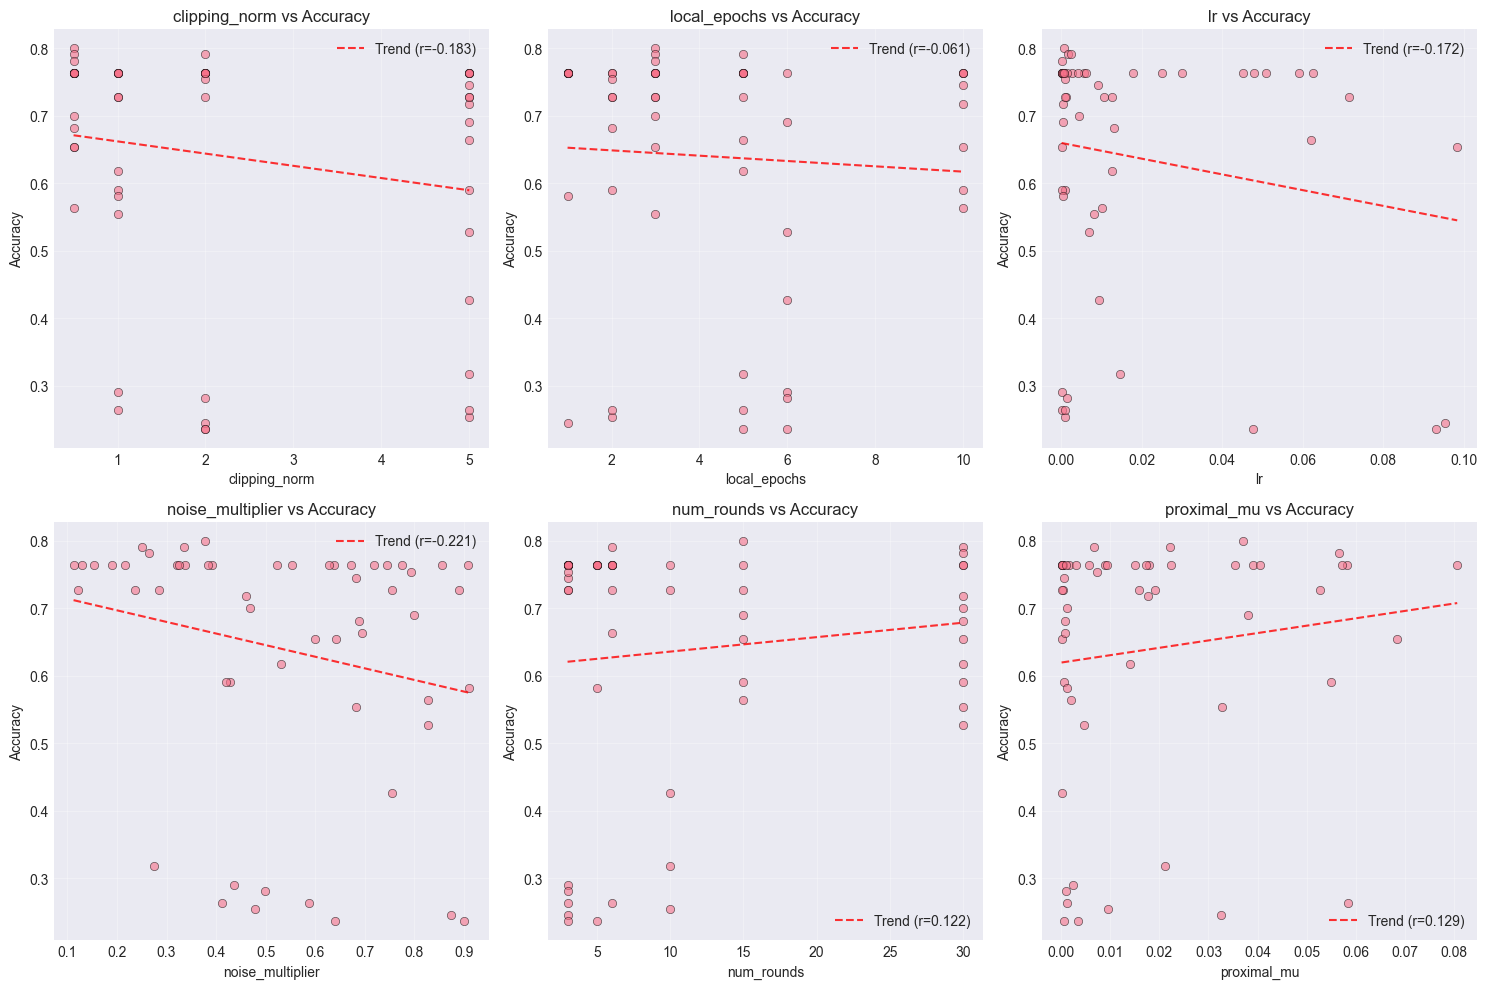

Based on top 25% performing runs:
  clipping_norm: [0.500000, 5.000000]
  local_epochs: [1.000000, 6.000000]
  lr: [0.000108, 0.062597]
  noise_multiplier: [0.154452, 0.744160]
  num_rounds: [3.000000, 30.000000]
  proximal_mu: [0.000149, 0.058210]

--- Summary ---
Optimal learning rate range: 0.0006 - 0.0299
Optimal num_rounds: 3
Optimal local_epochs: 3
Optimal clipping_norm: 0.5
Recommended noise_multiplier: < 0.3354
Recommended proximal_mu: 0.001640 - 0.036941


In [12]:
# Cell: Analyze WandB Random Search Results for FedProx with DP

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Load the wandb export
df = pd.read_csv('random_search_results.csv')

# Convert columns to appropriate types
df['clipping_norm'] = pd.to_numeric(df['clipping_norm'])
df['local_epochs'] = pd.to_numeric(df['local_epochs'])
df['lr'] = pd.to_numeric(df['lr'])
df['noise_multiplier'] = pd.to_numeric(df['noise_multiplier'])
df['num_rounds'] = pd.to_numeric(df['num_rounds'])
df['proximal_mu'] = pd.to_numeric(df['proximal_mu'])
df['final_test_loss'] = pd.to_numeric(df['final_test_loss'])
df['final_test_acc'] = pd.to_numeric(df['final_test_acc'])


print("=" * 60)
print("FedProx with DP - Hyperparameter Analysis")
print("=" * 60)
print(f"\nTotal runs analyzed: {len(df)}")

# Display hyperparameter ranges
print("\n--- Hyperparameter Ranges ---")
hyperparams = ['clipping_norm', 'local_epochs', 'lr', 'noise_multiplier', 'num_rounds', 'proximal_mu']
for hp in hyperparams:
    print(f"{hp}: min={df[hp].min():.6f}, max={df[hp].max():.6f}, unique={df[hp].nunique()}")


# --- Find Best Configuration ---
print("\n" + "=" * 60)
print("TOP 10 CONFIGURATIONS (by final test accuracy)")
print("=" * 60)

top_configs = df.nlargest(10, 'final_test_acc')[
    ['Name', 'lr', 'num_rounds', 'local_epochs', 'clipping_norm', 
     'noise_multiplier', 'proximal_mu', 'final_test_acc']
]
print(top_configs.to_string(index=False))

# Best configuration
best_idx = df['final_test_acc'].idxmax()
best_config = df.loc[best_idx]

print("\n" + "=" * 60)
print("BEST HYPERPARAMETER CONFIGURATION")
print("=" * 60)
print(f"Run Name: {best_config['Name']}")
print(f"Learning Rate: {best_config['lr']:.6f}")
print(f"Num Rounds: {int(best_config['num_rounds'])}")
print(f"Local Epochs: {int(best_config['local_epochs'])}")
print(f"Clipping Norm: {best_config['clipping_norm']:.2f}")
print(f"Noise Multiplier: {best_config['noise_multiplier']:.4f}")
print(f"Proximal Mu (FedProx): {best_config['proximal_mu']:.6f}")
print(f"Final Test Accuracy: {best_config['final_test_acc']:.4f}")
print(f"Final Test Loss: {best_config['final_test_loss']:.4f}")

# --- Correlation Analysis ---
print("\n" + "=" * 60)
print("CORRELATION WITH PERFORMANCE")
print("=" * 60)

correlations = df[hyperparams + ['final_test_acc']].corr()['final_test_acc'].drop('final_test_acc')
correlations_sorted = correlations.abs().sort_values(ascending=False)

for hp in correlations_sorted.index:
    corr_val = correlations[hp]
    print(f"{hp}: {corr_val:+.4f} ({'positive' if corr_val > 0 else 'negative'} impact)")

# --- Visualization ---
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, hp in enumerate(hyperparams):
    ax = axes[i]
    ax.scatter(df[hp], df['final_test_acc'], alpha=0.6, edgecolors='black', linewidth=0.5)
    
    # Add trend line
    z = np.polyfit(df[hp], df['final_test_acc'], 1)
    p = np.poly1d(z)
    x_line = np.linspace(df[hp].min(), df[hp].max(), 100)
    ax.plot(x_line, p(x_line), "r--", alpha=0.8, label=f'Trend (r={correlations[hp]:.3f})')
    
    ax.set_xlabel(hp)
    ax.set_ylabel('Accuracy')
    ax.set_title(f'{hp} vs Accuracy')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('results/fedprox_dp_hyperparameter_analysis.png', dpi=150, bbox_inches='tight')
plt.show()



# Based on top 25% performers
top_25_pct = df.nlargest(int(len(df) * 0.25), 'final_test_acc')

print("Based on top 25% performing runs:")
for hp in hyperparams:
    print(f"  {hp}: [{top_25_pct[hp].min():.6f}, {top_25_pct[hp].max():.6f}]")

print("\n--- Summary ---")
print(f"Optimal learning rate range: {top_25_pct['lr'].quantile(0.25):.4f} - {top_25_pct['lr'].quantile(0.75):.4f}")
print(f"Optimal num_rounds: {int(top_25_pct['num_rounds'].mode().values[0])}")
print(f"Optimal local_epochs: {int(top_25_pct['local_epochs'].mode().values[0])}")
print(f"Optimal clipping_norm: {top_25_pct['clipping_norm'].mode().values[0]}")
print(f"Recommended noise_multiplier: < {top_25_pct['noise_multiplier'].quantile(0.5):.4f}")
print(f"Recommended proximal_mu: {top_25_pct['proximal_mu'].quantile(0.25):.6f} - {top_25_pct['proximal_mu'].quantile(0.75):.6f}")